In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import torchmetrics

import cv2

In [26]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = 'results/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny. Only One Head. Weighted for Precision.')

# Config

In [4]:
CLASSES = ["smoke", "fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# Dataset

# DFire

In [5]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 ds_len,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.ds_len = ds_len
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), 
                                    ToTensorV2(p=1),
                                    ]
                                )

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
    
        if ds_len is not None:
            random.seed(123)
            random.shuffle(self.labels_list)
            self.images_path, self.labels = self.__build_ds__(self.labels_list[:self.ds_len])
            self.num_samples = len(self.labels_list[:self.ds_len])
        else:
            self.images_path, self.labels = self.__build_ds__(self.labels_list)
            self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
        empty = 0
        only_smoke = 0
        only_fire = 0
        smoke_fire = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, np.array([1, 1])):
                            break
                        else:
                            label_array[class_id] = 1.

                    if np.array_equal(label_array, np.array([1, 1])):
                        smoke_fire += 1
                    elif np.array_equal(label_array, np.array([0, 1])):
                        only_fire += 1
                    elif np.array_equal(label_array, np.array([1, 0])):
                        only_smoke += 1
                    elif np.array_equal(label_array, np.array([0, 0])):
                        empty += 1
                    else:
                        print("Wrong label in DFire dataset")
                        logger.info("Wrong label in DFire dataset")
                        
                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire empty images: {empty}')
        logger.info(f'DFire empty images: {empty}')
        print(f'DFire only smoke images: {only_smoke}')
        logger.info(f'DFire only smoke images: {only_smoke}')
        print(f'DFire only fire images: {only_fire}')
        logger.info(f'DFire only fire images: {only_fire}')
        print(f'DFire smoke and fire images: {smoke_fire}')
        logger.info(f'DFire smoke and fire images: {smoke_fire}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                #img = aug['image'] / 255.0
                img = aug['image'] 
            except:
                #print(f'Error trying to augment image {img_file}')
                # img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)
                # img = (img / 255.0) - 0.5 
                # img = torch.tensor(img, dtype=torch.float32)
                # img = img.permute(2, 0, 1)
                aug = self.except_transform(image=img)
                img = aug['image'] 
        
        return img, label

### View Dataset

In [6]:
ds_dir = '../../../datasets/ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels', '.ipynb_checkpoints', 'images']
val dir: ['labels', '.ipynb_checkpoints', 'images']


### Transform

In [7]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [8]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = DFireDataset(img_h=IMG_H, 
                             img_w=IMG_W, 
                             img_dir=val_imgs, 
                             label_dir=val_labels, 
                             num_classes=N_CLASSES,
                             ds_len=2*VIEW_BATCH_SIZE,
                             transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

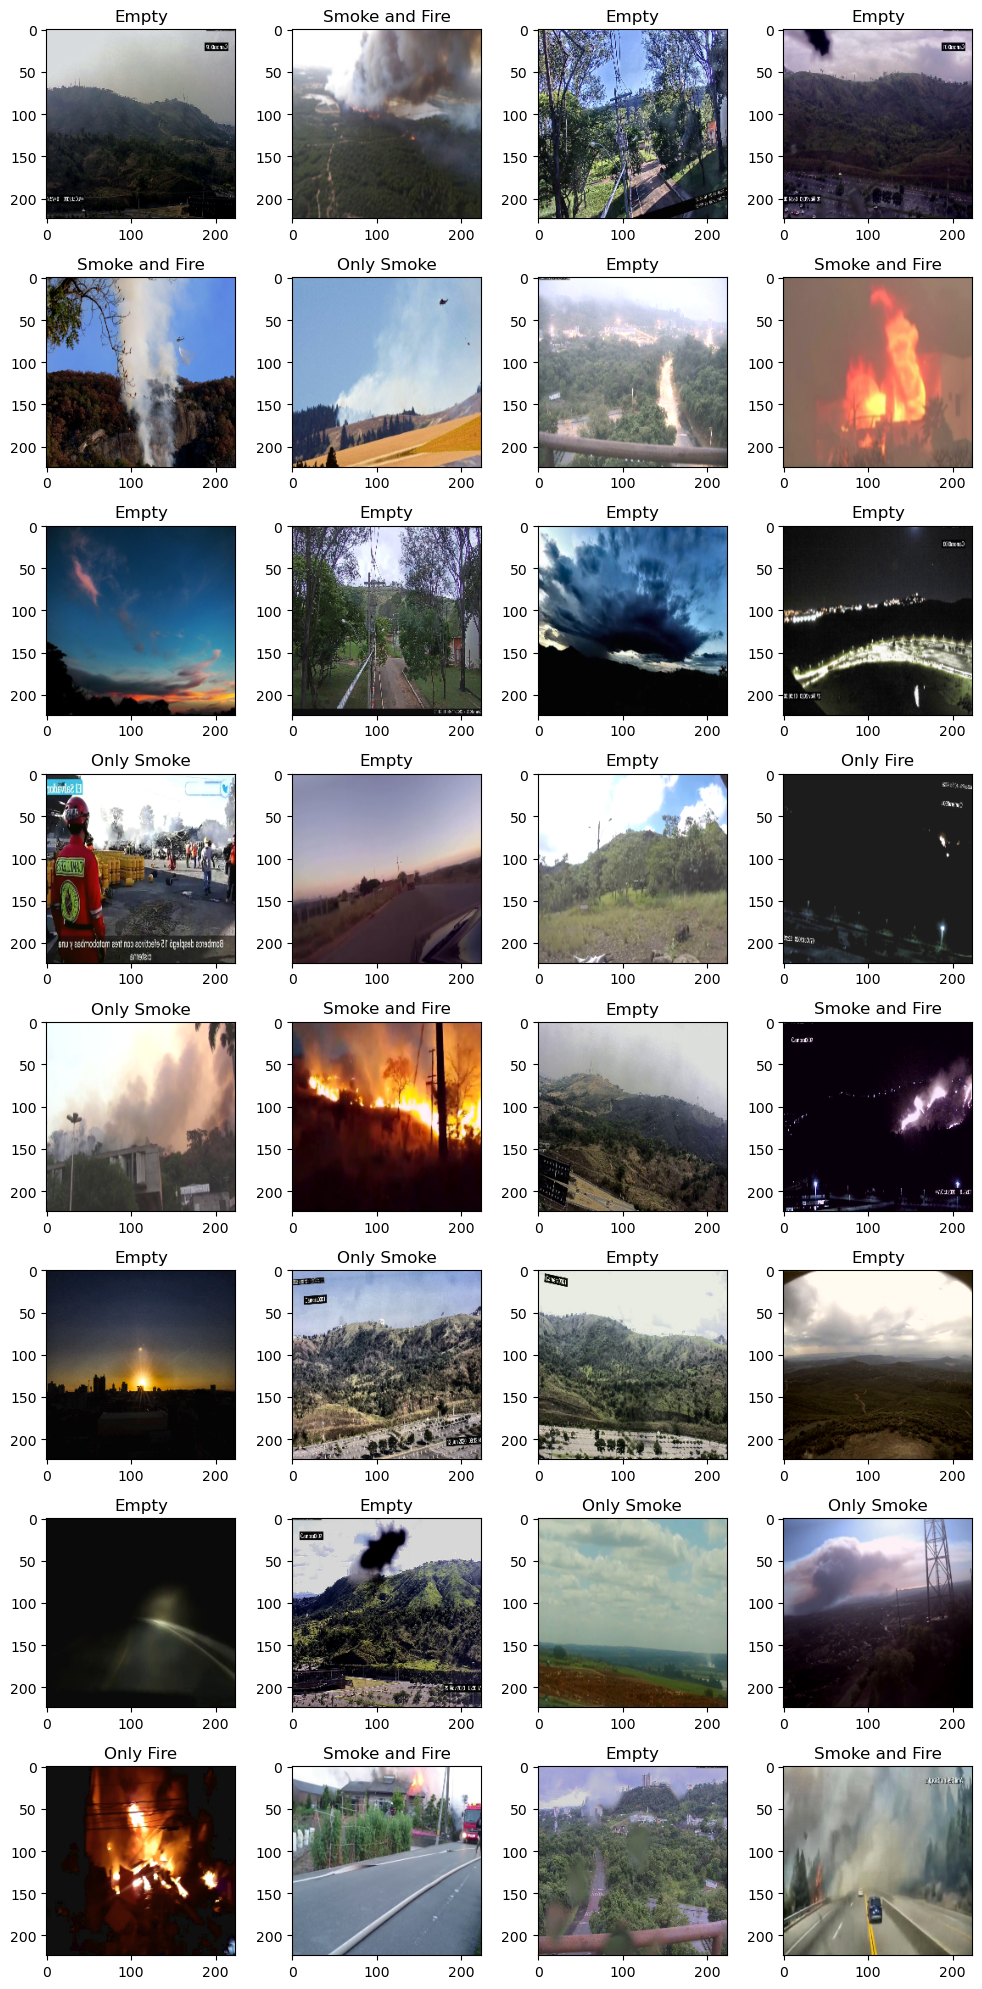

In [9]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Model: BED Less Layers

In [12]:
class BED_CLASSIFIER(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(BED_CLASSIFIER, self).__init__()
        self.in_channels = in_channels
        self.last_channels = 64
        self.num_classes = num_classes
        
        self.model = self.__create_BED__()
        
        #self.pool = nn.AdaptiveAvgPool2d((1, 1))
        # self.smoke = nn.Sequential(
        #     nn.Dropout(p=0.2),
        #     nn.Linear(in_features=self.last_channels, out_features=16),
        #     nn.ReLU(),
        #     nn.Linear(in_features=16, out_features=1)
        # )
        # self.fire = nn.Sequential(
        #     nn.Dropout(p=0.2),
        #     nn.Linear(in_features=self.last_channels, out_features=16),
        #     nn.ReLU(),
        #     nn.Linear(in_features=16, out_features=1)
        # )

        
    def __create_BED__(self):
        BED_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 224x224
            nn.Conv2d(self.in_channels, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 112x112
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 24, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(24, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 56x56
            nn.MaxPool2d(kernel_size=2, stride=2),
            # kernel = 1 in github
            nn.Conv2d(24, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            # kernel = 1 in github
            nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 28x28
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # Output One Head, 2 Neurons
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(start_dim=1),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=2),
            
        )
        return BED_model
        
          

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.model(x)
        return x

# Loss

In [13]:
class BCE_LOSS(nn.Module):
    '''
    dataset output: (image, {smoke: x, fire: x})
    model output: {smoke: x, fire: x}
    '''

    def __init__(self, device, smoke_precision_weight):
        super(BCE_LOSS, self).__init__()
        self.smoke_precision_weight = smoke_precision_weight
        self.device = device
        #self.bce = nn.BCELoss(reduction='mean')
        self.pos_weight = torch.tensor([self.smoke_precision_weight]).to(self.device)
        self.bce_smoke = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=self.pos_weight)
        self.bce_fire = nn.BCEWithLogitsLoss(reduction='sum')
        
        self.eps = 1e-10
        
        self.smoke_loss = 0
        self.fire_loss = 0

    def forward(self, ground_truth, predictions):
        
        # print(f'Ground trunth: {ground_truth}')
        # print(f'Predictions: {predictions}')
        
        # BCELoss: ALWAYS (prediction, target) -> it crashes with NaN if order is wrong
        smoke_loss = self.bce_smoke(predictions[..., 0],
                                    ground_truth[..., 0])
        self.smoke_loss = smoke_loss.item()
        fire_loss = self.bce_fire(predictions[..., 1],
                                  ground_truth[..., 1])
        self.fire_loss = fire_loss.item()
        
        total_loss = smoke_loss + fire_loss
        
        return total_loss

    def get_last_losses(self):     
        return {
            'smoke_loss': self.smoke_loss,
            'fire_loss': self.fire_loss,
        }

# Hyperparameters

In [14]:
''' ============================
    Hyperparameters and More
============================ '''

MODEL = "BED"
#MODEL = "SQUEEZE"

#LEARNING_RATE = 5e-4
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#DEVICE = "cpu"
BATCH_SIZE = 64 
WEIGHT_DECAY = 1e-4
#WEIGHT_DECAY = 0
EPOCHS = 75 #100
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
if MODEL == "BED":
    LOAD_MODEL_FILE = log_path + "bed_classifier_best.pt"
elif MODEL == "SQUEEZE":
    LOAD_MODEL_FILE = log_path + "squeeze_classifier_best.pt"

LOSS_FN = "BCE"
SMOKE_PRECISION_WEIGHT = 0.7

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
VAL_IMG_DIR = val_imgs
VAL_LABEL_DIR = val_labels

LOG_FILE = "log_file.xlsx"

DS_LEN = None


''' ============================
    Metrics
============================ '''
# Loss output
## Train
train_total_loss = []
train_smoke_loss = []
train_fire_loss = []
## Val
val_total_loss = []
val_smoke_loss = []
val_fire_loss = []

# Accuracy, Precision, Recall, F1
## Train
train_smoke_total_accuracy = []
train_smoke_total_precision = []
train_smoke_total_recall = []
train_smoke_total_f1 = []
train_fire_total_accuracy = []
train_fire_total_precision = []
train_fire_total_recall = []
train_fire_total_f1 = []
## Val
val_smoke_total_accuracy = []
val_smoke_total_precision = []
val_smoke_total_recall = []
val_smoke_total_f1 = []
val_fire_total_accuracy = []
val_fire_total_precision = []
val_fire_total_recall = []
val_fire_total_f1 = []

epochs_plot = []

# Metrics

In [15]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to(DEVICE)
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to(DEVICE)
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to(DEVICE)
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to(DEVICE)

# Train Loop

In [16]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
    logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)
      
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        train_losses.append(train_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
        
        # print(f'Train loss: {train_loss}')
        # print(f'Train loss: {train_losses}')
        
        model.eval()
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
        model.train()
    
    model.eval()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    model.train()
        
    logger.info("\nTRAIN losses")
    train_mean_loss = sum(train_losses)/len(train_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)


    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (train_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Validation Loop

In [17]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)      
        
        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        val_losses.append(val_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
    
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
    
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()

    logger.info("\nVAL losses")
    val_mean_loss = sum(val_losses)/len(val_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)

    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   

    logger.info("VAL Metrics")
    print(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    logger.info(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    print(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    logger.info(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (val_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Dataset Setup

In [18]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = DFireDataset(img_h = IMG_H,
                             img_w = IMG_W,
                             img_dir = TRAIN_IMG_DIR,
                             label_dir = TRAIN_LABEL_DIR,
                             num_classes=N_CLASSES,
                             ds_len = DS_LEN,
                             transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = DFireDataset(img_h = IMG_H,
                           img_w = IMG_W,
                           img_dir = VAL_IMG_DIR,
                           label_dir = VAL_LABEL_DIR,
                           num_classes = N_CLASSES,
                           ds_len = DS_LEN,
                           transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Model Setup

In [19]:
''' ======================================
    SETUP: Model, Loss, Dataset, Loader
====================================== '''
if MODEL == "BED":
    print("Using BED Classifier")
    logger.info("Using BED Classifier")
    model = BED_CLASSIFIER(num_classes=N_CLASSES).to(DEVICE)
elif MODEL == "SQUEEZE":
    print("Using Squeeze Classifier")
    logger.info("Using Squeeze Classifier")
    model = SqueezeNet(num_classes=N_CLASSES).to(DEVICE)    
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

# Check model shape
in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{model}')


optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.SGD(model.parameters(), 
#                             lr=LEARNING_RATE,
#                             momentum=0.9, 
#                             weight_decay=WEIGHT_DECAY, 
#                             nesterov=True)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=0.8, 
                                                 patience=2, 
                                                 threshold=0.001, 
                                                 threshold_mode='abs',
                                                 min_lr=1e-6)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier
Model shape is tensor([[-0.0074, -0.0635],
        [-0.0221, -0.1332],
        [-0.0753, -0.0047],
        [-0.0079, -0.1189]], device='cuda:0', grad_fn=<AddmmBackward0>)
BED Model Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(24, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (11): BatchNorm2d(16, eps=1e-05, mo

# Main Function

In [20]:
def main(model):

    ''' ============================
        Print Config Values
    ============================ '''
    print(f'Device: {DEVICE}')
    print(f'Learning Rate: {LEARNING_RATE}')
    print(f'Weight Decay: {WEIGHT_DECAY}')
    print(f'Batch Size: {BATCH_SIZE}')
    print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    print(f'W: {IMG_W}\nH: {IMG_H}')
    
    logger.info(f'Device: {DEVICE}')
    logger.info(f'Learning Rate: {LEARNING_RATE}')
    logger.info(f'Weight Decay: {WEIGHT_DECAY}')
    logger.info(f'Batch Size: {BATCH_SIZE}')
    logger.info(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    logger.info(f'W: {IMG_W}\nH: {IMG_H}')

    
    # LOSS FUNCTION
    if LOSS_FN == "BCE":
        print(f'Loss Function: BCE')
        logger.info(f'Loss Function: BCE')
        print(f'Smoke Precision Weight: {SMOKE_PRECISION_WEIGHT}')
        logger.info(f'Smoke Precision Weight: {SMOKE_PRECISION_WEIGHT}')
        loss_fn = BCE_LOSS(device=DEVICE, smoke_precision_weight=SMOKE_PRECISION_WEIGHT)
    else:
        print("Wrong loss function")
        logger.info("Wrong loss function")
        raise SystemExit("Wrong loss function")

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = torch.tensor([0.])

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = 0

    if LOAD_MODEL == False:
        if MODEL == "BED":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
        elif MODEL == "SQUEEZE":
            print("Weights already initialize in model call")
            logger.info("Weights already initialize in model call")
    else:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    for epoch in range(start_epoch, EPOCHS):

        print(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        
        # TRAINING
        train_loss, smoke_loss, fire_loss, tr_acc, tr_pre, tr_rec, tr_f1 = train_fn(loader=train_loader, 
                                                                                    model=model, 
                                                                                    optimizer=optimizer, 
                                                                                    loss_fn=loss_fn,
                                                                                    device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(train_loss)
        train_smoke_loss.append(smoke_loss)
        train_fire_loss.append(fire_loss)
        # Appending Train Metrics
        train_smoke_total_accuracy.append(tr_acc[0].detach().to('cpu'))
        train_smoke_total_precision.append(tr_pre[0].detach().to('cpu'))
        train_smoke_total_recall.append(tr_rec[0].detach().to('cpu'))
        train_smoke_total_f1.append(tr_f1[0].detach().to('cpu'))
        train_fire_total_accuracy.append(tr_acc[1].detach().to('cpu'))
        train_fire_total_precision.append(tr_pre[1].detach().to('cpu'))
        train_fire_total_recall.append(tr_rec[1].detach().to('cpu'))
        train_fire_total_f1.append(tr_f1[1].detach().to('cpu'))
        
        # VALIDATING
        with torch.no_grad():
            val_loss, smoke_loss, fire_loss, v_acc, v_pre, v_rec, v_f1 = eval_fn(loader=val_loader, 
                                                                                 model=model,                         
                                                                                 loss_fn=loss_fn,
                                                                                 device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(val_loss)
            val_smoke_loss.append(smoke_loss)
            val_fire_loss.append(fire_loss)
            # Appending Validation Metrics
            val_smoke_total_accuracy.append(v_acc[0].detach().to('cpu'))
            val_smoke_total_precision.append(v_pre[0].detach().to('cpu'))
            val_smoke_total_recall.append(v_rec[0].detach().to('cpu'))
            val_smoke_total_f1.append(v_f1[0].detach().to('cpu'))
            val_fire_total_accuracy.append(v_acc[1].detach().to('cpu'))
            val_fire_total_precision.append(v_pre[1].detach().to('cpu'))
            val_fire_total_recall.append(v_rec[1].detach().to('cpu'))
            val_fire_total_f1.append(v_f1[1].detach().to('cpu'))
            
            scheduler.step(val_loss)
            

            epochs_plot.append(epoch)
            plt.plot(epochs_plot, train_total_loss, label="Train Loss")
            plt.plot(epochs_plot, val_total_loss, label="Val Loss")
            plt.title("Train vs Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_loss.png")
            plt.close()
            
            # Accuracy
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_accuracy, label="Smoke Train Acc")
            plt.plot(epochs_plot, val_smoke_total_accuracy, label="Smoke Val Acc")
            plt.title("Smoke Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_acc.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_accuracy, label="Fire Train Acc")
            plt.plot(epochs_plot, val_fire_total_accuracy, label="Fire Val Acc")
            plt.title("Fire Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_acc.png")
            plt.close()
            # Precision
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_precision, label="Smoke Train Prec")
            plt.plot(epochs_plot, val_smoke_total_precision, label="Smoke Val Prec")
            plt.title("Smoke Train vs Val Precision")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_prec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_precision, label="Fire Train Prec")
            plt.plot(epochs_plot, val_fire_total_precision, label="Fire Val Prec")
            plt.title("Fire Train vs Val Prec")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_prec.png")
            plt.close()
            # Recall
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_recall, label="Smoke Train Rec")
            plt.plot(epochs_plot, val_smoke_total_recall, label="Smoke Val Rec")
            plt.title("Smoke Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_rec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_recall, label="Fire Train Rec")
            plt.plot(epochs_plot, val_fire_total_recall, label="Fire Val Rec")
            plt.title("Fire Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_rec.png")
            plt.close()
            # F1
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_f1, label="Smoke Train F1")
            plt.plot(epochs_plot, val_smoke_total_f1, label="Smoke Val F1")
            plt.title("Smoke Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_f1.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_f1, label="Fire Train F1")
            plt.plot(epochs_plot, val_fire_total_f1, label="Fire Val F1")
            plt.title("Fire Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_f1.png")
            plt.close()

        if ( (epoch+1) % 5 ) == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'bed_classifier_5epoch.pt') 
            
        if best_valid_loss > val_loss:
            best_valid_loss = val_loss
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_bed_classifier.pt') 

        if best_smoke_precision < v_pre[0].detach().to('cpu'):
            best_smoke_precision = v_pre[0].detach().to('cpu')
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_smoke_bed_classifier.pt') 
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + 'last_bed_classifier.pt') 
    
#     save_log(epochs=EPOCHS, 
#              train_total_loss=train_total_loss,
#              train_box_loss=train_box_loss,
#              train_class_loss=train_class_loss,
#              train_confidence_loss=train_confidence_loss,
#              train_noobj_loss=train_noobj_loss,
#              train_mAP=train_mAP,
#              train_class_AP=train_class_AP,
#              train_class_precision=train_class_precision,
#              train_class_recall=train_class_recall,
#              val_total_loss=val_total_loss,
#              val_box_loss=val_box_loss,
#              val_class_loss=val_class_loss,
#              val_confidence_loss=val_confidence_loss,
#              val_noobj_loss=val_noobj_loss,
#              val_mAP=val_mAP,
#              val_class_AP=val_class_AP,
#              val_class_precision=val_class_precision,
#              val_class_recall=val_class_recall,
#              log_file_dst=LOG_FILE)

    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [21]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    model_trained = main(model=model)

Starting script

Device: cuda
Learning Rate: 0.001
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)
W: 224
H: 224
Loss Function: BCE
Smoke Precision Weight: 0.7

***Start Training: 13:46:04

Initializing Weights

=== EPOCH 0/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:11<00:00,  3.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
67.334      |36.513      |30.820      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.484      |35.985      |24.499      

SMOKE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.519 - F1: 0.000
FIRE -> Precision: 0.736 - Recall: 0.537 - Accuracy: 0.830 - F1: 0.621

Saving model with new best validation loss: 60.484

=== EPOCH 1/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
62.203      |35.816      |26.387      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
59.039      |36.057      |22.982      

SMOKE -> Precision: 0.589 - Recall: 0.203 - Accuracy: 0.548 - F1: 0.301
FIRE -> Precision: 0.782 - Recall: 0.568 - Accuracy: 0.847 - F1: 0.658

Saving model with new best validation loss: 59.039

Saving model with new best smoke precision: 0.589

=== EPOCH 2/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.241      |35.485      |24.756      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.957      |35.177      |22.781      

SMOKE -> Precision: 0.605 - Recall: 0.264 - Accuracy: 0.563 - F1: 0.368
FIRE -> Precision: 0.766 - Recall: 0.614 - Accuracy: 0.851 - F1: 0.681

Saving model with new best validation loss: 57.957

Saving model with new best smoke precision: 0.605

=== EPOCH 3/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
59.048      |35.192      |23.857      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.417      |35.230      |21.187      

SMOKE -> Precision: 0.653 - Recall: 0.286 - Accuracy: 0.583 - F1: 0.398
FIRE -> Precision: 0.796 - Recall: 0.634 - Accuracy: 0.863 - F1: 0.706

Saving model with new best validation loss: 56.417

Saving model with new best smoke precision: 0.653

=== EPOCH 4/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.588      |34.919      |22.669      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.439      |34.536      |19.903      

SMOKE -> Precision: 0.677 - Recall: 0.368 - Accuracy: 0.612 - F1: 0.477
FIRE -> Precision: 0.774 - Recall: 0.699 - Accuracy: 0.869 - F1: 0.735

Saving model with new best validation loss: 54.439

Saving model with new best smoke precision: 0.677

=== EPOCH 5/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:11<00:00,  3.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.335      |34.600      |21.734      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.986      |34.025      |18.962      

SMOKE -> Precision: 0.693 - Recall: 0.343 - Accuracy: 0.611 - F1: 0.459
FIRE -> Precision: 0.822 - Recall: 0.672 - Accuracy: 0.877 - F1: 0.739

Saving model with new best validation loss: 52.986

Saving model with new best smoke precision: 0.693

=== EPOCH 6/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.228      |34.194      |21.034      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.410      |33.707      |18.703      

SMOKE -> Precision: 0.674 - Recall: 0.445 - Accuracy: 0.629 - F1: 0.536
FIRE -> Precision: 0.749 - Recall: 0.814 - Accuracy: 0.881 - F1: 0.780

Saving model with new best validation loss: 52.410

=== EPOCH 7/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.492      |33.953      |20.539      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.514      |33.803      |17.711      

SMOKE -> Precision: 0.692 - Recall: 0.382 - Accuracy: 0.621 - F1: 0.493
FIRE -> Precision: 0.820 - Recall: 0.743 - Accuracy: 0.891 - F1: 0.780

Saving model with new best validation loss: 51.514

=== EPOCH 8/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.197      |33.435      |19.762      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.610      |33.263      |18.348      

SMOKE -> Precision: 0.717 - Recall: 0.376 - Accuracy: 0.628 - F1: 0.493
FIRE -> Precision: 0.855 - Recall: 0.677 - Accuracy: 0.887 - F1: 0.756

Saving model with new best smoke precision: 0.717

=== EPOCH 9/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:13<00:00,  3.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.772      |33.265      |19.507      



Validating: 100%|███████████████████████████████| 67/67 [00:10<00:00,  6.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.902      |31.983      |15.919      

SMOKE -> Precision: 0.727 - Recall: 0.470 - Accuracy: 0.660 - F1: 0.571
FIRE -> Precision: 0.833 - Recall: 0.779 - Accuracy: 0.903 - F1: 0.805

Saving model with new best validation loss: 47.902

Saving model with new best smoke precision: 0.727

=== EPOCH 10/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:13<00:00,  3.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.965      |33.078      |18.887      



Validating: 100%|███████████████████████████████| 67/67 [00:10<00:00,  6.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.189      |32.044      |16.145      

SMOKE -> Precision: 0.711 - Recall: 0.470 - Accuracy: 0.653 - F1: 0.566
FIRE -> Precision: 0.794 - Recall: 0.832 - Accuracy: 0.900 - F1: 0.812

=== EPOCH 11/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:13<00:00,  3.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.980      |32.494      |18.486      



Validating: 100%|███████████████████████████████| 67/67 [00:10<00:00,  6.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.560      |31.864      |15.696      

SMOKE -> Precision: 0.713 - Recall: 0.466 - Accuracy: 0.653 - F1: 0.564
FIRE -> Precision: 0.816 - Recall: 0.821 - Accuracy: 0.906 - F1: 0.818

Saving model with new best validation loss: 47.560

=== EPOCH 12/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:14<00:00,  3.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.586      |31.658      |17.928      



Validating: 100%|███████████████████████████████| 67/67 [00:10<00:00,  6.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.599      |28.392      |15.207      

SMOKE -> Precision: 0.817 - Recall: 0.564 - Accuracy: 0.729 - F1: 0.667
FIRE -> Precision: 0.849 - Recall: 0.801 - Accuracy: 0.912 - F1: 0.824

Saving model with new best validation loss: 43.599

Saving model with new best smoke precision: 0.817

=== EPOCH 13/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:14<00:00,  3.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.704      |30.551      |17.153      



Validating: 100%|███████████████████████████████| 67/67 [00:10<00:00,  6.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.078      |27.261      |14.817      

SMOKE -> Precision: 0.803 - Recall: 0.611 - Accuracy: 0.741 - F1: 0.694
FIRE -> Precision: 0.879 - Recall: 0.775 - Accuracy: 0.914 - F1: 0.824

Saving model with new best validation loss: 42.078

=== EPOCH 14/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:14<00:00,  3.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.798      |29.860      |16.938      



Validating: 100%|███████████████████████████████| 67/67 [00:10<00:00,  6.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.602      |27.208      |14.395      

SMOKE -> Precision: 0.826 - Recall: 0.557 - Accuracy: 0.731 - F1: 0.666
FIRE -> Precision: 0.903 - Recall: 0.766 - Accuracy: 0.918 - F1: 0.829

Saving model with new best validation loss: 41.602

Saving model with new best smoke precision: 0.826

=== EPOCH 15/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.290      |29.470      |16.820      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.939      |26.068      |13.871      

SMOKE -> Precision: 0.827 - Recall: 0.623 - Accuracy: 0.756 - F1: 0.711
FIRE -> Precision: 0.871 - Recall: 0.808 - Accuracy: 0.919 - F1: 0.838

Saving model with new best validation loss: 39.939

Saving model with new best smoke precision: 0.827

=== EPOCH 16/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.155      |28.897      |16.257      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.614      |25.384      |14.230      

SMOKE -> Precision: 0.819 - Recall: 0.649 - Accuracy: 0.762 - F1: 0.724
FIRE -> Precision: 0.870 - Recall: 0.785 - Accuracy: 0.914 - F1: 0.825

Saving model with new best validation loss: 39.614

=== EPOCH 17/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.300      |28.327      |15.974      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.731      |24.396      |13.335      

SMOKE -> Precision: 0.803 - Recall: 0.757 - Accuracy: 0.794 - F1: 0.779
FIRE -> Precision: 0.842 - Recall: 0.862 - Accuracy: 0.923 - F1: 0.852

Saving model with new best validation loss: 37.731

=== EPOCH 18/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:11<00:00,  3.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.531      |27.671      |15.860      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.007      |24.706      |13.301      

SMOKE -> Precision: 0.835 - Recall: 0.662 - Accuracy: 0.774 - F1: 0.738
FIRE -> Precision: 0.884 - Recall: 0.799 - Accuracy: 0.921 - F1: 0.840

Saving model with new best smoke precision: 0.835

=== EPOCH 19/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.005      |27.525      |15.480      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.617      |23.944      |12.673      

SMOKE -> Precision: 0.868 - Recall: 0.611 - Accuracy: 0.768 - F1: 0.717
FIRE -> Precision: 0.881 - Recall: 0.812 - Accuracy: 0.923 - F1: 0.845

Saving model with new best validation loss: 36.617

Saving model with new best smoke precision: 0.868

=== EPOCH 20/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.416      |27.035      |15.381      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.236      |22.839      |12.397      

SMOKE -> Precision: 0.819 - Recall: 0.802 - Accuracy: 0.819 - F1: 0.810
FIRE -> Precision: 0.834 - Recall: 0.877 - Accuracy: 0.923 - F1: 0.855

Saving model with new best validation loss: 35.236

=== EPOCH 21/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.332      |26.432      |14.900      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.436      |24.236      |12.200      

SMOKE -> Precision: 0.881 - Recall: 0.563 - Accuracy: 0.753 - F1: 0.687
FIRE -> Precision: 0.918 - Recall: 0.815 - Accuracy: 0.933 - F1: 0.864

Saving model with new best smoke precision: 0.881

=== EPOCH 22/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:11<00:00,  3.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.951      |26.240      |14.711      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.100      |24.079      |15.020      

SMOKE -> Precision: 0.902 - Recall: 0.542 - Accuracy: 0.751 - F1: 0.677
FIRE -> Precision: 0.926 - Recall: 0.689 - Accuracy: 0.905 - F1: 0.790

Saving model with new best smoke precision: 0.902

=== EPOCH 23/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.152      |25.829      |14.322      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.791      |22.025      |11.767      

SMOKE -> Precision: 0.867 - Recall: 0.683 - Accuracy: 0.797 - F1: 0.764
FIRE -> Precision: 0.911 - Recall: 0.807 - Accuracy: 0.930 - F1: 0.856

Saving model with new best validation loss: 33.791

=== EPOCH 24/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.667      |25.416      |14.251      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.717      |22.312      |11.405      

SMOKE -> Precision: 0.825 - Recall: 0.754 - Accuracy: 0.805 - F1: 0.788
FIRE -> Precision: 0.895 - Recall: 0.832 - Accuracy: 0.931 - F1: 0.862

Saving model with new best validation loss: 33.717

=== EPOCH 25/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.176      |25.358      |13.817      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.023      |21.172      |11.851      

SMOKE -> Precision: 0.874 - Recall: 0.728 - Accuracy: 0.819 - F1: 0.794
FIRE -> Precision: 0.934 - Recall: 0.775 - Accuracy: 0.927 - F1: 0.847

Saving model with new best validation loss: 33.023

=== EPOCH 26/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:13<00:00,  3.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.612      |24.928      |13.685      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.490      |20.826      |11.665      

SMOKE -> Precision: 0.840 - Recall: 0.804 - Accuracy: 0.832 - F1: 0.822
FIRE -> Precision: 0.920 - Recall: 0.791 - Accuracy: 0.928 - F1: 0.851

Saving model with new best validation loss: 32.490

=== EPOCH 27/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.796      |24.959      |13.838      



Validating: 100%|███████████████████████████████| 67/67 [00:10<00:00,  6.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.175      |21.134      |11.041      

SMOKE -> Precision: 0.873 - Recall: 0.724 - Accuracy: 0.816 - F1: 0.792
FIRE -> Precision: 0.938 - Recall: 0.803 - Accuracy: 0.935 - F1: 0.865

Saving model with new best validation loss: 32.175

=== EPOCH 28/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:13<00:00,  3.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.230      |24.713      |13.516      



Validating: 100%|███████████████████████████████| 67/67 [00:10<00:00,  6.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.906      |21.856      |11.050      

SMOKE -> Precision: 0.920 - Recall: 0.595 - Accuracy: 0.780 - F1: 0.723
FIRE -> Precision: 0.935 - Recall: 0.802 - Accuracy: 0.934 - F1: 0.863

Saving model with new best smoke precision: 0.920

=== EPOCH 29/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:13<00:00,  3.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.478      |24.204      |13.274      



Validating: 100%|███████████████████████████████| 67/67 [00:10<00:00,  6.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.975      |23.366      |12.609      

SMOKE -> Precision: 0.895 - Recall: 0.601 - Accuracy: 0.774 - F1: 0.719
FIRE -> Precision: 0.929 - Recall: 0.773 - Accuracy: 0.926 - F1: 0.844

=== EPOCH 30/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:14<00:00,  3.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.327      |24.822      |13.505      



Validating: 100%|███████████████████████████████| 67/67 [00:10<00:00,  6.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.108      |20.903      |10.205      

SMOKE -> Precision: 0.895 - Recall: 0.683 - Accuracy: 0.809 - F1: 0.774
FIRE -> Precision: 0.911 - Recall: 0.871 - Accuracy: 0.944 - F1: 0.890

Saving model with new best validation loss: 31.108

=== EPOCH 31/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:13<00:00,  3.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.336      |24.107      |13.229      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  6.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.876      |19.529      |11.347      

SMOKE -> Precision: 0.848 - Recall: 0.825 - Accuracy: 0.845 - F1: 0.836
FIRE -> Precision: 0.948 - Recall: 0.797 - Accuracy: 0.936 - F1: 0.866

Saving model with new best validation loss: 30.876

=== EPOCH 32/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.622      |23.909      |12.713      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.089      |19.905      |10.184      

SMOKE -> Precision: 0.898 - Recall: 0.737 - Accuracy: 0.833 - F1: 0.810
FIRE -> Precision: 0.917 - Recall: 0.851 - Accuracy: 0.942 - F1: 0.883

Saving model with new best validation loss: 30.089

=== EPOCH 33/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.410      |23.662      |12.749      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.734      |19.305      |9.429       

SMOKE -> Precision: 0.894 - Recall: 0.767 - Accuracy: 0.844 - F1: 0.826
FIRE -> Precision: 0.933 - Recall: 0.855 - Accuracy: 0.947 - F1: 0.892

Saving model with new best validation loss: 28.734

=== EPOCH 34/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:11<00:00,  3.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.234      |23.440      |12.794      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.204      |18.660      |9.544       

SMOKE -> Precision: 0.859 - Recall: 0.814 - Accuracy: 0.846 - F1: 0.836
FIRE -> Precision: 0.924 - Recall: 0.874 - Accuracy: 0.949 - F1: 0.898

Saving model with new best validation loss: 28.204

=== EPOCH 35/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:11<00:00,  3.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.080      |23.381      |12.699      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.156      |18.882      |10.275      

SMOKE -> Precision: 0.883 - Recall: 0.781 - Accuracy: 0.845 - F1: 0.829
FIRE -> Precision: 0.942 - Recall: 0.834 - Accuracy: 0.944 - F1: 0.885

=== EPOCH 36/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.065      |23.289      |12.776      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.453      |18.860      |9.594       

SMOKE -> Precision: 0.857 - Recall: 0.837 - Accuracy: 0.855 - F1: 0.847
FIRE -> Precision: 0.904 - Recall: 0.884 - Accuracy: 0.946 - F1: 0.894

=== EPOCH 37/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:53<00:00,  5.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.312      |22.725      |12.587      



Validating: 100%|███████████████████████████████| 67/67 [00:08<00:00,  8.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.945      |18.772      |10.174      

SMOKE -> Precision: 0.862 - Recall: 0.813 - Accuracy: 0.847 - F1: 0.837
FIRE -> Precision: 0.918 - Recall: 0.841 - Accuracy: 0.940 - F1: 0.878

=== EPOCH 38/74 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.673      |22.516      |12.157      



Validating: 100%|███████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.152      |18.024      |9.128       

SMOKE -> Precision: 0.900 - Recall: 0.791 - Accuracy: 0.857 - F1: 0.842
FIRE -> Precision: 0.925 - Recall: 0.874 - Accuracy: 0.949 - F1: 0.899

Saving model with new best validation loss: 27.152

=== EPOCH 39/74 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.371      |22.386      |11.985      



Validating: 100%|███████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.802      |17.579      |9.223       

SMOKE -> Precision: 0.890 - Recall: 0.799 - Accuracy: 0.856 - F1: 0.842
FIRE -> Precision: 0.901 - Recall: 0.890 - Accuracy: 0.946 - F1: 0.896

Saving model with new best validation loss: 26.802

=== EPOCH 40/74 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.116      |22.036      |12.080      



Validating: 100%|███████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.083      |16.957      |9.125       

SMOKE -> Precision: 0.882 - Recall: 0.844 - Accuracy: 0.871 - F1: 0.863
FIRE -> Precision: 0.938 - Recall: 0.865 - Accuracy: 0.950 - F1: 0.900

Saving model with new best validation loss: 26.083

=== EPOCH 41/74 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.637      |22.039      |11.598      



Validating: 100%|███████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.234      |17.344      |9.890       

SMOKE -> Precision: 0.885 - Recall: 0.821 - Accuracy: 0.863 - F1: 0.852
FIRE -> Precision: 0.951 - Recall: 0.839 - Accuracy: 0.947 - F1: 0.891

=== EPOCH 42/74 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.510      |21.952      |11.558      



Validating: 100%|███████████████████████████████| 67/67 [00:08<00:00,  8.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.747      |17.773      |8.974       

SMOKE -> Precision: 0.909 - Recall: 0.768 - Accuracy: 0.852 - F1: 0.833
FIRE -> Precision: 0.929 - Recall: 0.874 - Accuracy: 0.950 - F1: 0.901

=== EPOCH 43/74 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.404      |21.718      |11.687      



Validating: 100%|███████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.359      |17.891      |9.468       

SMOKE -> Precision: 0.868 - Recall: 0.848 - Accuracy: 0.865 - F1: 0.858
FIRE -> Precision: 0.941 - Recall: 0.855 - Accuracy: 0.949 - F1: 0.896

=== EPOCH 44/74 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.956      |21.305      |11.651      



Validating: 100%|███████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.346      |17.114      |9.232       

SMOKE -> Precision: 0.866 - Recall: 0.851 - Accuracy: 0.865 - F1: 0.858
FIRE -> Precision: 0.884 - Recall: 0.930 - Accuracy: 0.950 - F1: 0.906

=== EPOCH 45/74 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.603      |21.286      |11.318      



Validating: 100%|███████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.539      |17.280      |9.259       

SMOKE -> Precision: 0.889 - Recall: 0.799 - Accuracy: 0.856 - F1: 0.842
FIRE -> Precision: 0.950 - Recall: 0.858 - Accuracy: 0.951 - F1: 0.902

=== EPOCH 46/74 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.305      |20.982      |11.323      



Validating: 100%|███████████████████████████████| 67/67 [00:08<00:00,  8.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.412      |16.738      |8.674       

SMOKE -> Precision: 0.890 - Recall: 0.828 - Accuracy: 0.868 - F1: 0.858
FIRE -> Precision: 0.935 - Recall: 0.884 - Accuracy: 0.954 - F1: 0.909

Saving model with new best validation loss: 25.412

=== EPOCH 47/74 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:47<00:00,  5.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.288      |20.985      |11.303      



Validating: 100%|███████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.798      |16.191      |8.607       

SMOKE -> Precision: 0.902 - Recall: 0.812 - Accuracy: 0.867 - F1: 0.854
FIRE -> Precision: 0.928 - Recall: 0.891 - Accuracy: 0.954 - F1: 0.909

Saving model with new best validation loss: 24.798

=== EPOCH 48/74 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.294      |21.032      |11.262      



Validating: 100%|███████████████████████████████| 67/67 [00:08<00:00,  8.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.231      |16.081      |9.150       

SMOKE -> Precision: 0.887 - Recall: 0.849 - Accuracy: 0.875 - F1: 0.868
FIRE -> Precision: 0.953 - Recall: 0.849 - Accuracy: 0.950 - F1: 0.898

=== EPOCH 49/74 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.089      |20.910      |11.179      



Validating: 100%|███████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.925      |16.375      |8.550       

SMOKE -> Precision: 0.877 - Recall: 0.852 - Accuracy: 0.872 - F1: 0.865
FIRE -> Precision: 0.921 - Recall: 0.897 - Accuracy: 0.953 - F1: 0.909

=== EPOCH 50/74 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.976      |21.008      |10.968      



Validating: 100%|███████████████████████████████| 67/67 [00:08<00:00,  8.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.133      |15.804      |9.329       

SMOKE -> Precision: 0.894 - Recall: 0.854 - Accuracy: 0.881 - F1: 0.874
FIRE -> Precision: 0.953 - Recall: 0.843 - Accuracy: 0.949 - F1: 0.895

=== EPOCH 51/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:47<00:00,  5.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.043      |20.229      |10.814      



Validating: 100%|███████████████████████████████| 67/67 [00:08<00:00,  8.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.108      |15.522      |8.586       

SMOKE -> Precision: 0.903 - Recall: 0.833 - Accuracy: 0.876 - F1: 0.866
FIRE -> Precision: 0.941 - Recall: 0.882 - Accuracy: 0.955 - F1: 0.911

Saving model with new best validation loss: 24.108

=== EPOCH 52/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:47<00:00,  5.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.885      |20.060      |10.825      



Validating: 100%|███████████████████████████████| 67/67 [00:08<00:00,  8.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.842      |15.515      |9.326       

SMOKE -> Precision: 0.907 - Recall: 0.837 - Accuracy: 0.880 - F1: 0.870
FIRE -> Precision: 0.969 - Recall: 0.832 - Accuracy: 0.950 - F1: 0.895

=== EPOCH 53/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:47<00:00,  5.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.952      |20.080      |10.872      



Validating: 100%|███████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.426      |14.874      |8.552       

SMOKE -> Precision: 0.902 - Recall: 0.858 - Accuracy: 0.887 - F1: 0.880
FIRE -> Precision: 0.915 - Recall: 0.910 - Accuracy: 0.955 - F1: 0.912

Saving model with new best validation loss: 23.426

=== EPOCH 54/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:48<00:00,  5.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.737      |20.077      |10.660      



Validating: 100%|███████████████████████████████| 67/67 [00:08<00:00,  8.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.671      |15.404      |9.266       

SMOKE -> Precision: 0.901 - Recall: 0.841 - Accuracy: 0.879 - F1: 0.870
FIRE -> Precision: 0.957 - Recall: 0.840 - Accuracy: 0.949 - F1: 0.894

=== EPOCH 55/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [01:02<00:00,  4.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.728      |19.817      |10.911      



Validating: 100%|███████████████████████████████| 67/67 [00:10<00:00,  6.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.694      |16.570      |9.123       

SMOKE -> Precision: 0.927 - Recall: 0.768 - Accuracy: 0.859 - F1: 0.840
FIRE -> Precision: 0.961 - Recall: 0.859 - Accuracy: 0.954 - F1: 0.907

Saving model with new best smoke precision: 0.927

=== EPOCH 56/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.947      |20.129      |10.819      



Validating: 100%|███████████████████████████████| 67/67 [00:10<00:00,  6.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.773      |15.388      |9.385       

SMOKE -> Precision: 0.899 - Recall: 0.837 - Accuracy: 0.876 - F1: 0.867
FIRE -> Precision: 0.946 - Recall: 0.856 - Accuracy: 0.950 - F1: 0.899

=== EPOCH 57/74 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [01:13<00:00,  3.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.130      |19.558      |10.573      



Validating: 100%|███████████████████████████████| 67/67 [00:10<00:00,  6.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.019      |14.654      |8.365       

SMOKE -> Precision: 0.898 - Recall: 0.857 - Accuracy: 0.884 - F1: 0.877
FIRE -> Precision: 0.929 - Recall: 0.895 - Accuracy: 0.955 - F1: 0.912

Saving model with new best validation loss: 23.019

=== EPOCH 58/74 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [01:13<00:00,  3.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.590      |19.265      |10.325      



Validating: 100%|███████████████████████████████| 67/67 [00:10<00:00,  6.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.172      |14.920      |9.253       

SMOKE -> Precision: 0.901 - Recall: 0.841 - Accuracy: 0.879 - F1: 0.870
FIRE -> Precision: 0.949 - Recall: 0.852 - Accuracy: 0.950 - F1: 0.898

=== EPOCH 59/74 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [01:13<00:00,  3.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.453      |19.294      |10.159      



Validating: 100%|███████████████████████████████| 67/67 [00:10<00:00,  6.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.243      |14.819      |8.424       

SMOKE -> Precision: 0.919 - Recall: 0.826 - Accuracy: 0.881 - F1: 0.870
FIRE -> Precision: 0.944 - Recall: 0.873 - Accuracy: 0.954 - F1: 0.907

=== EPOCH 60/74 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [01:13<00:00,  3.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.362      |19.016      |10.346      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  6.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.505      |14.471      |8.034       

SMOKE -> Precision: 0.887 - Recall: 0.887 - Accuracy: 0.891 - F1: 0.887
FIRE -> Precision: 0.938 - Recall: 0.906 - Accuracy: 0.960 - F1: 0.922

Saving model with new best validation loss: 22.505

=== EPOCH 61/74 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.319      |19.031      |10.289      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.562      |15.114      |9.447       

SMOKE -> Precision: 0.922 - Recall: 0.812 - Accuracy: 0.877 - F1: 0.864
FIRE -> Precision: 0.964 - Recall: 0.835 - Accuracy: 0.949 - F1: 0.895

=== EPOCH 62/74 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [01:10<00:00,  3.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.303      |19.135      |10.168      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.926      |14.805      |9.121       

SMOKE -> Precision: 0.920 - Recall: 0.815 - Accuracy: 0.877 - F1: 0.865
FIRE -> Precision: 0.962 - Recall: 0.835 - Accuracy: 0.949 - F1: 0.894

=== EPOCH 63/74 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [01:10<00:00,  3.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.604      |19.245      |10.360      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.509      |15.235      |8.274       

SMOKE -> Precision: 0.928 - Recall: 0.790 - Accuracy: 0.870 - F1: 0.854
FIRE -> Precision: 0.941 - Recall: 0.886 - Accuracy: 0.956 - F1: 0.912

Saving model with new best smoke precision: 0.928

=== EPOCH 64/74 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [01:11<00:00,  3.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.111      |18.898      |10.213      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.715      |14.742      |7.974       

SMOKE -> Precision: 0.873 - Recall: 0.919 - Accuracy: 0.897 - F1: 0.896
FIRE -> Precision: 0.939 - Recall: 0.897 - Accuracy: 0.958 - F1: 0.918

=== EPOCH 65/74 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.706      |18.707      |9.999       



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.966      |14.145      |8.821       

SMOKE -> Precision: 0.915 - Recall: 0.848 - Accuracy: 0.889 - F1: 0.880
FIRE -> Precision: 0.953 - Recall: 0.862 - Accuracy: 0.953 - F1: 0.905

=== EPOCH 66/74 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [01:13<00:00,  3.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.725      |18.737      |9.988       



Validating: 100%|███████████████████████████████| 67/67 [00:10<00:00,  6.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.758      |14.413      |8.345       

SMOKE -> Precision: 0.923 - Recall: 0.828 - Accuracy: 0.884 - F1: 0.873
FIRE -> Precision: 0.952 - Recall: 0.869 - Accuracy: 0.955 - F1: 0.909

=== EPOCH 67/74 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [01:13<00:00,  3.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.014      |18.039      |9.975       



Validating: 100%|███████████████████████████████| 67/67 [00:10<00:00,  6.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.483      |13.593      |7.890       

SMOKE -> Precision: 0.908 - Recall: 0.869 - Accuracy: 0.895 - F1: 0.888
FIRE -> Precision: 0.932 - Recall: 0.896 - Accuracy: 0.956 - F1: 0.914

Saving model with new best validation loss: 21.483

=== EPOCH 68/74 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [01:13<00:00,  3.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.548      |18.331      |10.217      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.067      |13.843      |8.224       

SMOKE -> Precision: 0.914 - Recall: 0.854 - Accuracy: 0.891 - F1: 0.883
FIRE -> Precision: 0.942 - Recall: 0.879 - Accuracy: 0.955 - F1: 0.910

=== EPOCH 69/74 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.397      |18.348      |10.049      



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.020      |13.902      |8.117       

SMOKE -> Precision: 0.913 - Recall: 0.858 - Accuracy: 0.892 - F1: 0.885
FIRE -> Precision: 0.948 - Recall: 0.881 - Accuracy: 0.957 - F1: 0.913

=== EPOCH 70/74 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [01:11<00:00,  3.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.792      |18.263      |9.529       



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.112      |13.979      |8.133       

SMOKE -> Precision: 0.918 - Recall: 0.840 - Accuracy: 0.887 - F1: 0.877
FIRE -> Precision: 0.949 - Recall: 0.874 - Accuracy: 0.955 - F1: 0.910

=== EPOCH 71/74 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [01:11<00:00,  3.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.704      |17.800      |9.904       



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.690      |13.402      |8.288       

SMOKE -> Precision: 0.919 - Recall: 0.873 - Accuracy: 0.902 - F1: 0.895
FIRE -> Precision: 0.946 - Recall: 0.868 - Accuracy: 0.953 - F1: 0.906

=== EPOCH 72/74 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [01:11<00:00,  3.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.298      |17.862      |9.435       



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.599      |13.343      |8.256       

SMOKE -> Precision: 0.895 - Recall: 0.900 - Accuracy: 0.901 - F1: 0.897
FIRE -> Precision: 0.942 - Recall: 0.876 - Accuracy: 0.954 - F1: 0.908

=== EPOCH 73/74 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [01:11<00:00,  3.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.484      |17.832      |9.652       



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.196      |13.524      |7.672       

SMOKE -> Precision: 0.923 - Recall: 0.849 - Accuracy: 0.893 - F1: 0.884
FIRE -> Precision: 0.915 - Recall: 0.914 - Accuracy: 0.956 - F1: 0.914

Saving model with new best validation loss: 21.196

=== EPOCH 74/74 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [01:12<00:00,  3.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.891      |18.107      |9.783       



Validating: 100%|███████████████████████████████| 67/67 [00:11<00:00,  5.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.762      |13.337      |8.424       

SMOKE -> Precision: 0.911 - Recall: 0.876 - Accuracy: 0.899 - F1: 0.893
FIRE -> Precision: 0.955 - Recall: 0.866 - Accuracy: 0.955 - F1: 0.908

***Script finished: 15:23:14

Time elapsed: 1:37:10.000417


# Confusion Matrix

In [22]:
# smoke_conf_mtx_metric = torchmetrics.classification.BinaryConfusionMatrix(threshold = 0.5).to(DEVICE)
# fire_conf_mtx_metric = torchmetrics.classification.BinaryConfusionMatrix(threshold = 0.5).to(DEVICE)

In [23]:
# def get_conf_mtx(loader, model, device):

#     model.eval()
#     loop = tqdm(loader, desc='Validating', leave=True)

#     for batch_idx, (x, y) in enumerate(loop):
#         x, y = x.to(device), y.to(device)
#         out = model(x) 
    
#         # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
#         #yhat = torch.sigmoid(out.detach())
#         yhat = out.detach() # La metrica entiende que son logits y aplica sigmoid
#         smoke_conf_mtx_metric.update(yhat[..., 0], y[..., 0])
#         fire_conf_mtx_metric.update(yhat[..., 1], y[..., 1])
    
#     smoke_conf_mtx = smoke_conf_mtx_metric.compute()
#     fire_conf_mtx = fire_conf_mtx_metric.compute()
#     # smoke_conf_mtx_metric.reset()
#     # fire_conf_mtx_metric.reset()
    
#     return smoke_conf_mtx, fire_conf_mtx

In [24]:
# smoke_conf_mtx, fire_conf_mtx = get_conf_mtx(loader=val_loader,
#                                              model=model_trained,
#                                              device=DEVICE)
# print(smoke_conf_mtx)
# print(fire_conf_mtx)

Validating:   7%|██▍                             | 5/67 [00:02<00:26,  2.32it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 784.00 MiB. GPU 

### Smoke confusion matrix

In [ ]:
# fig, ax = smoke_conf_mtx_metric.plot()
# fig.suptitle("Smoke Confusion Matrix")
# fig.set_size_inches(3,3)
# fig.savefig("xs_ultra_tiny_precision_weighted_save/smoke_conf_mtx.png")

### Fire confusion matrix

In [ ]:
# fig, ax = fire_conf_mtx_metric.plot()
# fig.suptitle("Fire Confusion Matrix")
# fig.set_size_inches(3,3)
# fig.savefig("xs_ultra_tiny_precision_weighted_save/fire_conf_mtx.png")

# Confusion Matrix 4 classes

In [ ]:
# def get_conf_mtx_4_classes(loader, model, device):

#     empty_row = np.zeros((4))
#     smoke_row = np.zeros((4))
#     fire_row = np.zeros((4))
#     smoke_fire_row = np.zeros((4))  

#     empty = torch.tensor([0, 0], dtype= torch.float32).to(device)
#     smoke = torch.tensor([1, 0], dtype= torch.float32).to(device)
#     fire = torch.tensor([0, 1], dtype= torch.float32).to(device)
#     smoke_fire = torch.tensor([1, 1], dtype= torch.float32).to(device)
    
#     model.eval()
#     loop = tqdm(loader, desc='Validating', leave=True)

#     for batch_idx, (x, y) in enumerate(loop):
#         x, y = x.to(device), y.to(device)
#         out = model(x) 
#         yhat = torch.round(torch.sigmoid(out.detach()))
        
#         for i in range(x.shape[0]):
#             # Empty class
#             if torch.equal(y[i], empty):
#                 if torch.equal(yhat[i], empty):
#                     empty_row[0] += 1
#                 elif torch.equal(yhat[i], smoke):
#                     empty_row[1] += 1
#                 elif torch.equal(yhat[i], fire):
#                     empty_row[2] += 1
#                 elif torch.equal(yhat[i], smoke_fire):
#                     empty_row[3] += 1
#                 else:
#                     print("Error")
#             # Smoke class
#             if torch.equal(y[i], smoke):
#                 if torch.equal(yhat[i], empty):
#                     smoke_row[0] += 1
#                 elif torch.equal(yhat[i], smoke):
#                     smoke_row[1] += 1
#                 elif torch.equal(yhat[i], fire):
#                     smoke_row[2] += 1
#                 elif torch.equal(yhat[i], smoke_fire):
#                     smoke_row[3] += 1
#                 else:
#                     print("Error")
#             # Fire class
#             if torch.equal(y[i], fire):
#                 if torch.equal(yhat[i], empty):
#                     fire_row[0] += 1
#                 elif torch.equal(yhat[i], smoke):
#                     fire_row[1] += 1
#                 elif torch.equal(yhat[i], fire):
#                     fire_row[2] += 1
#                 elif torch.equal(yhat[i], smoke_fire):
#                     fire_row[3] += 1
#                 else:
#                     print("Error")
#             # Smoke and Fire class
#             if torch.equal(y[i], smoke_fire):
#                 if torch.equal(yhat[i], empty):
#                     smoke_fire_row[0] += 1
#                 elif torch.equal(yhat[i], smoke):
#                     smoke_fire_row[1] += 1
#                 elif torch.equal(yhat[i], fire):
#                     smoke_fire_row[2] += 1
#                 elif torch.equal(yhat[i], smoke_fire):
#                     smoke_fire_row[3] += 1
#                 else:
#                     print("Error")
    
#     return np.stack((empty_row, smoke_row, fire_row, smoke_fire_row))

In [ ]:
# conf_mtx_4 = get_conf_mtx_4_classes(loader=val_loader, 
#                                     model=model_trained,
#                                     device=DEVICE)

In [ ]:
# print(conf_mtx_4)

In [ ]:
# conf_mtx_4[0, ...] = conf_mtx_4[0, ...] / np.sum(conf_mtx_4[0, ...])
# conf_mtx_4[1, ...] = conf_mtx_4[1, ...] / np.sum(conf_mtx_4[1, ...])
# conf_mtx_4[2, ...] = conf_mtx_4[2, ...] / np.sum(conf_mtx_4[2, ...])
# conf_mtx_4[3, ...] = conf_mtx_4[3, ...] / np.sum(conf_mtx_4[3, ...])
# fig, ax = plt.subplots()
# fig.suptitle('Conf MTX Normalized')
# ax.matshow(conf_mtx_4, cmap='RdPu')
# for (i, j), z in np.ndenumerate(conf_mtx_4):
#     ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
# #ax.matshow(conf_mtx_4, cmap='Blues')
# #ax.set_xticklabels(['empty', 'smoke', 'fire', 'smoke & fire'])
# ax.set_xlabel('Predicted')
# ax.set_ylabel('True')
# ax.set_yticks(range(4), ['empty', 'smoke', 'fire', 'smoke & fire'])
# ax.set_xticks(range(4), ['empty', 'smoke', 'fire', 'smoke & fire'])
# plt.show()

# Plot Results

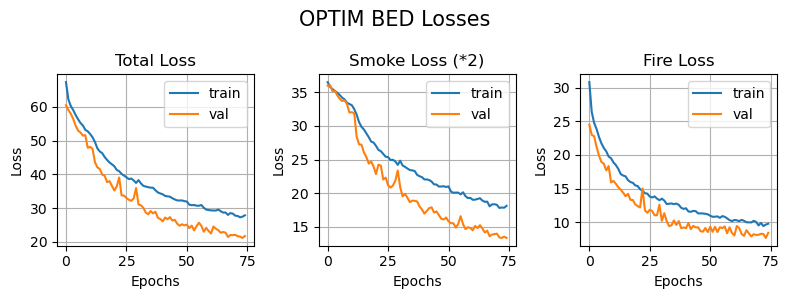

In [25]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(1,3, figsize=(8, 3))
fig.suptitle('OPTIM BED Losses', fontsize=15)

plt.subplot(1,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_smoke_loss, label="train")
plt.plot(val_smoke_loss, label="val")
plt.title("Smoke Loss (*2)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(train_fire_loss, label="train")
plt.plot(val_fire_loss, label="val")
plt.title("Fire Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + "bed_losses.png")
plt.show()